In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
import os
import math
import logging
import sys
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SphericalRepresentation, CartesianRepresentation

In [2]:
simname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/mag2/Chinchilla-4-y3wlpz.0.fits"
truthname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/Chinchilla-4_lensed.4.fits"

In [3]:
simhdu = fits.open(simname)
truthhdu = fits.open(truthname)

In [4]:
#simhdu.info()
sim_table = simhdu[1].data
#print(sim_table.columns);

#truthhdu.info()
truth_table = truthhdu[1].data
#print(truth_table.columns)

In [5]:
cat_file_name = os.path.join('/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/','Chinchilla-4_lensed.4.fits')
cat = galsim.Catalog(cat_file_name)

In [ ]:

   # final2 = galsim.Convolve([gal])
   # image2 = galsim.ImageF(48, 48)
   # nfimages.append(image1)
   # final2.drawImage(image2, scale=0.2)
   # image2.addNoise(galsim.GaussianNoise(rng, 0.005*gflux))
   # nimages.append(image2)
  #  image1.addNoise(galsim.GaussianNoise(rng, 0.0005))
      #gal = galsim.Gaussian(flux=gflux, half_light_radius=hlr)
      #shearing = galsim.Shear(e1=elip1, e2=elip2)

In [147]:
noisy_file_name = os.path.join('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject','noisy.fits')
noisefree_file_name = os.path.join('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject','noisefree.fits')


rband = truth_table['LMAG'][:,1] #grizy
te1 = truth_table['EPSILON'][:,0]
te2 = truth_table['EPSILON'][:,1]

In [ ]:
# half light radius squared/flux
def imagefunc(n=100):
    _nimages, _moments, noisematrix, results, _matrices, rotations, gfluxes, hlr1, failures =([] for i in range(9))
    for i in range(0, n):

        # catalogs
        ra = cat.get(i, 'RA')
        dec = cat.get(i, 'DEC')
        hlr = cat.get(i, 'SIZE')
        hlr1.append(hlr)
        # more catalogs
        elip1 = te1[i]
        elip2 = te2[i]
        lmag = rband[i]
        gflux = 10**((lmag-22.5)/(-2.5))
        gfluxes.append(gflux)

        gal = galsim.Gaussian(flux=gflux, half_light_radius=hlr)
        # shearing and transformation matrix

        shearing1 = galsim.Shear(e1=elip1, e2=elip2)
        shearing2 = galsim.Shear(e1=-1*elip1, e2=elip2)
        gal = gal.shear(shearing1)
        matrix = (shearing2.getMatrix())*(hlr**2)*25
        _matrices.append(matrix)
       # rng = galsim.BaseDeviate(30+i+1)

        # create image, convolve

        image1 = galsim.ImageF(48, 48)
        final1 = galsim.Convolve([gal])
        final1.drawImage(image1, scale=0.2)
        
        image1.addNoise(galsim.GaussianNoise(sigma=0.0005))
        _nimages.append(image1)

        moment = galsim.hsm.FindAdaptiveMom(image1, strict = False)
        _moments.append(moment)
        if moment.moments_n_iter == 0:
            failures.append(i)
    
        image3 = galsim.ImageF(48, 48)
        noise = galsim.GaussianNoise(sigma=0.0005)
    
        image3.addNoise(noise)
        noisematrix.append(image3.array)
    
        galsim.fits.writeMulti(nimages, noisy_file_name)
        #galsim.fits.writeMulti(nfimages, noisefree_file_name)
imagefunc(100)

In [ ]:
imagefunc(100)
matrices = [i for j, i in enumerate(_matrices) if j not in failures]
nimages = [i for j, i in enumerate(_nimages) if j not in failures]
moments = [i for j, i in enumerate(_moments) if j not in failures]
print(noisematrix)

In [193]:
from astropy.utils.data import get_pkg_data_filename
noisy_image_file = get_pkg_data_filename('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject/noisy.fits')
#noisefree_image_file = get_pkg_data_filename('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject/noisefree.fits')

In [197]:
HSMflux = []
cheatflux = []
newmatrices = []
sigmas = []
x, y = np.mgrid[-24:24:1, -24:24:1]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
for i in range(len(nimages)):
    HSMflux.append(moments[i].moments_amp - gfluxes[i])
    sigmas.append(moments[i].moments_sigma)
    newmatrices.append(moments[i].observed_shape.getMatrix()*(moments[i].moments_sigma)**2 * 25)

#for k in range(20):
#    print(hlr1[k] - sigmas[k]*0.2)
    
    
for j in range(len(nimages)):
    rv = multivariate_normal([0, 0], matrices[j])
    foo = np.sum(np.multiply(rv.pdf(pos), noisematrix[j]))
    cheatflux.append(foo)
    
plt.figure()

plt.scatter(HSMflux, cheatflux)
axes = plt.gca()
axes.set_ylim([-0.0005,0.0005])


TypeError: image[index] only accepts BoundsI or PositionI for the index

In [ ]:
plt.figure(1)
fluxes = []
f, ax = plt.subplots(3, 3, figsize=(11, 9))
for i in range(9):
    image_data = fits.getdata(noisy_image_file, ext = i)
    im = ax[i//3, i%3].imshow(image_data, origin="lower")
    f.colorbar(im, ax=ax[i//3, i%3])
plt.tight_layout(1)

<Figure size 432x288 with 0 Axes>

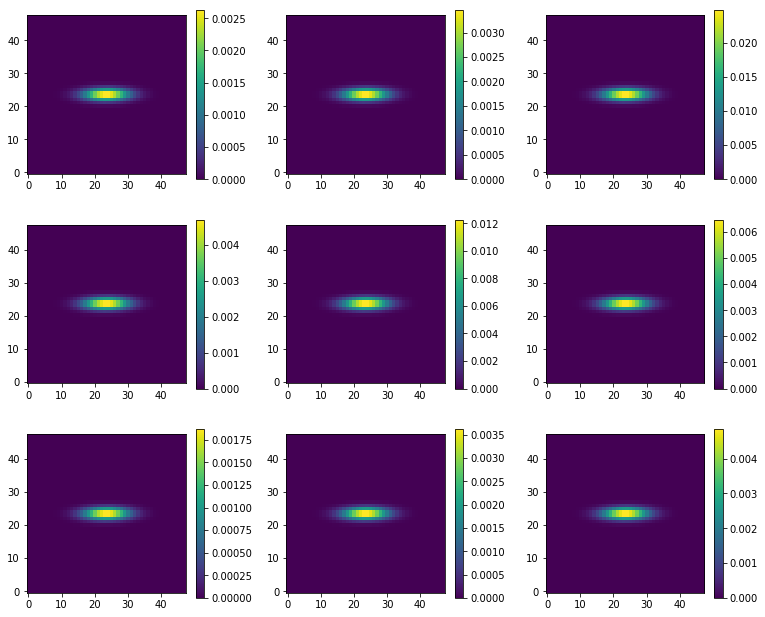

In [16]:
plt.figure(2)
g, ax = plt.subplots(3, 3, figsize=(11, 9))
x, y = np.mgrid[-23.5:24.5:1, -23.5:24.5:1]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

for j in range(0, 9):
    rv = multivariate_normal([0, 0], matrices[j])
  #  im = ax[j//3, j%3].contourf(x, y, gfluxes[j]*rv.pdf(pos))
    im = ax[j//3, j%3].imshow(gfluxes[j]*rv.pdf(pos), origin = "lower")
    f.colorbar(im, ax=ax[j//3, j%3])
plt.tight_layout(2)